In [1]:
import pandas as pd
import numpy as np
import re
from scipy.stats import linregress
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import linregress,pearsonr,spearmanr
from scipy.optimize import curve_fit
import statsmodels.api as sm

plt.rcParams["font.family"] = "Helvetica Neue"

In [2]:
palette = {"neurons":"C0", 
           "glia":"C1", 
           "maternal":"C2", 
           "paternal":"C3", 
           "lung":"C6", 
           "liver":"C9"}

In [3]:
pd.read_table("numbers-used-along-repair.tab").groupby("Tissue_CellType").size()

Tissue_CellType
Liver_never-smoker     433
Liver_smoker          1152
Lung_never-smoker      256
Lung_smoker            376
Neuron                  56
Oligo                   86
father                 451
mother                 451
dtype: int64

In [4]:
len(pd.read_csv("../data/Olafsson2020/Olafsson2020-signet.tab",sep="\t"))

897

In [5]:
ng = pd.read_table("../data/Ng2021/Ng2021-signet-smokers-along-repair.tab")
ngns = pd.read_table("../data/Ng2021/Ng2021-signet-never-smokers-along-repair.tab")
yos = pd.read_table("../data/Yoshida2020/Yoshida2020-signet-smokers-along-repair.tab")
yosns = pd.read_table("../data/Yoshida2020/Yoshida2020-signet-never-smokers-along-repair.tab")
colon = pd.read_table("../data/Olafsson2020/Olafsson2020-signet-smokers-along-repair.tab")
neurons = pd.read_table("../data/Ganz2024/Ganz2024-signet-neurons-along-repair.tab")
glia = pd.read_table("../data/Ganz2024/Ganz2024-signet-glia-along-repair.tab")
maternal = pd.read_table("../data/Germline/Germline-signet-maternal-along-repair.tab")
paternal = pd.read_table("../data/Germline/Germline-signet-paternal-along-repair.tab")

n_indivs = {"Liver_smoker": [ng, 1152], 
            "Liver_nonsmoker": [ngns, 433],
            "Lung_smoker": [yos, 376], 
            "Lung_nonsmoker": [yosns, 256], 
            "Neuron": [neurons, 56], 
            "Glia": [glia, 86],
            "Paternal": [paternal, 451],
            "Maternal": [maternal, 451], 
            "Intestine":[colon, 897]}

sigs = [c for c in yos.columns if c.startswith("nSBS")]

for k,v in n_indivs.items():
    df = v[0]
    for sig in sigs:
        df[sig] = df[sig] / v[1]
        if k not in ["Paternal", "Maternal"]:
            df[sig] = df[sig] / 2
    df["RepairRate"] = df["RepairRate"] * 1440
    
yos["Yoshida2020-clustersCA"] = yos["Yoshida2020-clustersCA"] / n_indivs["Lung_smoker"][1]
ng["Ng2021-clustersCA"] = ng["Ng2021-clustersCA"] / n_indivs["Liver_smoker"][1]

In [6]:
def mod_hyperbolic_model(r, a, b, rmin):
    return a / (r - rmin) + b

def plot_and_fit_curve(ax, df, x_col, y_col, label, color, **kwargs):

    xs = df[x_col].values
    ys = df[y_col].values
    norm = False
    if norm:
        fv = np.mean(ys[-10:])
    else:
        fv = 1

    # Plot the raw data points
    ax.scatter(xs, ys / fv, edgecolor='none', color=color, **kwargs)
    label = label.replace("non-smokers", "N").replace("smokers", "S")

    try:
        rmin_upper_bound = np.min(xs)
        lower_bounds = [-np.inf, 0, 0]
        upper_bounds = [np.inf, np.inf, rmin_upper_bound]
        initial_guesses = [1.0, np.min(ys), 0]

        popt, _ = curve_fit(
            mod_hyperbolic_model, xs, ys,
            p0=initial_guesses,
            bounds=(lower_bounds, upper_bounds),
            maxfev=5000
        )
        a_fit, b_fit, rmin_fit = popt

        # Calculate goodness of fit ---
        y_predicted = mod_hyperbolic_model(xs, *popt)
        residuals = ys - y_predicted
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((ys - np.mean(ys))**2)
        
        # Avoid division by zero if all y values are the same
        r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        rmse = np.sqrt(np.mean(residuals**2))

        ner_frac = b_fit / np.mean(ys)

        print(
            f"Fit for {y_col} ({label}): a={a_fit:.2f}, b={b_fit:.2f}, "
            f"r*={rmin_fit:.2f}, R2={r_squared:.2f}, "
            f"mean(y)={np.mean(ys):.2f}, NER_frac={ner_frac:.2f}"
        )

        # Plot the fitted curve
        xmin, xmax = ax.get_xlim()
        xmin, xmax = np.min(xs), np.max(xs)
        xmin = xmin * 0.975 if xmin>=rmin_fit else xmin
        x_curve = np.linspace(xmin, xmax, 500)
        y_curve = mod_hyperbolic_model(x_curve, *popt)
        ax.plot(x_curve, y_curve / fv, color=color, label=f"{label}: R$^{2}$={r_squared:.2f}", lw=2,
                ls="--" if "(N" in label else "-", alpha=0.8)

        # Annotate the plot with results

        ax.set_xlim([xmin, xmax])
        ax.set_xlabel("Repair rate (day$^{-1}$)")
        
        if norm:
            ax.set_ylabel("Fold mutation rate relative to high repair regions")
        else:
            lab_d = "clustered" if "cluster" in y_col else y_col[1:]
            lab_d = lab_d
            ax.set_ylabel(f"Average number of {lab_d} mutations")
        ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

        return {"params": popt, "r2": r_squared, "rmse": rmse}

    except RuntimeError:
        print(f"Could not fit curve for {y_col} ({label}).")
        return None


Fit for Yoshida2020-clustersCA (Lung (S)): a=0.02, b=0.00, r*=0.55, R2=0.54, mean(y)=0.06, NER_frac=0.00
Fit for Ng2021-clustersCA (Liver (S)): a=0.01, b=0.00, r*=0.48, R2=0.42, mean(y)=0.02, NER_frac=0.06
Fit for nSBS4 (Lung (S)): a=1.43, b=0.00, r*=0.58, R2=0.67, mean(y)=4.88, NER_frac=0.00
Fit for nSBS4 (Liver (S)): a=0.70, b=0.00, r*=0.56, R2=0.68, mean(y)=2.27, NER_frac=0.00
Fit for nSBS5 (Lung (S)): a=2.44, b=4.89, r*=0.50, R2=0.62, mean(y)=11.40, NER_frac=0.43
Fit for nSBS5 (Lung (N)): a=0.77, b=1.67, r*=0.42, R2=0.38, mean(y)=3.35, NER_frac=0.50
Fit for nSBS5 (Liver (S)): a=0.57, b=2.38, r*=0.55, R2=0.56, mean(y)=4.18, NER_frac=0.57
Fit for nSBS5 (Liver (N)): a=0.26, b=2.29, r*=0.54, R2=0.18, mean(y)=3.10, NER_frac=0.74


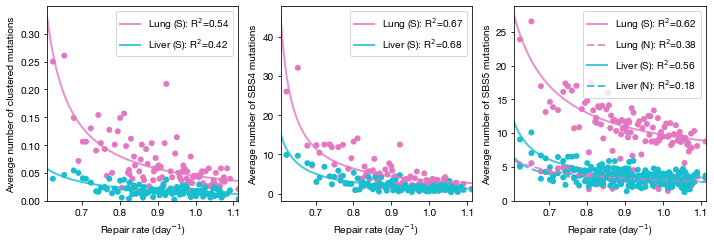

In [7]:
f,axs = plt.subplots(1,3,figsize=[10,3.5])

ax = axs[0]
plot_and_fit_curve(ax, yos,   "RepairRate", "Yoshida2020-clustersCA", "Lung (smokers)", palette["lung"])
plot_and_fit_curve(ax, ng,   "RepairRate", "Ng2021-clustersCA", "Liver (smokers)", palette["liver"])
ax.set_ylim(bottom=0)
ax.legend()

ax = axs[1]
plot_and_fit_curve(ax, yos,   "RepairRate", "nSBS4", "Lung (smokers)", palette["lung"])
plot_and_fit_curve(ax, ng,   "RepairRate", "nSBS4", "Liver (smokers)", palette["liver"])
#ax.set_ylim([0, 25e3])
ax.legend()

ax = axs[2]
plot_and_fit_curve(ax, yos,   "RepairRate", "nSBS5", "Lung (smokers)", palette["lung"])
plot_and_fit_curve(ax, yosns, "RepairRate", "nSBS5", "Lung (non-smokers)", palette["lung"])
plot_and_fit_curve(ax, ng,    "RepairRate", "nSBS5", "Liver (smokers)", palette["liver"])
plot_and_fit_curve(ax, ngns,  "RepairRate", "nSBS5", "Liver (non-smokers)", palette["liver"])
#ax.set_ylim([0, 25e3])
ax.legend()

plt.tight_layout()
#plt.savefig("pdfs/prefig4.pdf")

Fit for nSBS5 (Lung (S)): a=2.44, b=4.89, r*=0.50, R2=0.62, mean(y)=11.40, NER_frac=0.43
Fit for nSBS5 (Lung (N)): a=0.77, b=1.67, r*=0.42, R2=0.38, mean(y)=3.35, NER_frac=0.50
Fit for nSBS5 (Liver (S)): a=0.57, b=2.38, r*=0.55, R2=0.56, mean(y)=4.18, NER_frac=0.57
Fit for nSBS5 (Liver (N)): a=0.26, b=2.29, r*=0.54, R2=0.18, mean(y)=3.10, NER_frac=0.74


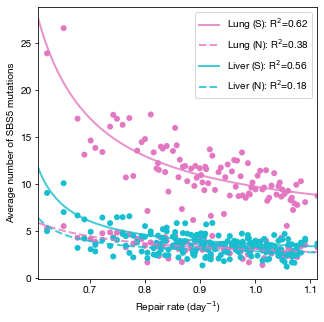

In [8]:
f,ax = plt.subplots(figsize=[5,5])
plot_and_fit_curve(ax, yos,   "RepairRate", "nSBS5", "Lung (smokers)", palette["lung"])
plot_and_fit_curve(ax, yosns, "RepairRate", "nSBS5", "Lung (non-smokers)", palette["lung"])
plot_and_fit_curve(ax, ng,    "RepairRate", "nSBS5", "Liver (smokers)", palette["liver"])
plot_and_fit_curve(ax, ngns,  "RepairRate", "nSBS5", "Liver (non-smokers)", palette["liver"])
ax.legend()

Fit for nSBS5 (Lung (S)): a=2.44, b=4.89, r*=0.50, R2=0.62, mean(y)=11.40, NER_frac=0.43


(0.623005261725168, 1.113330887445168)

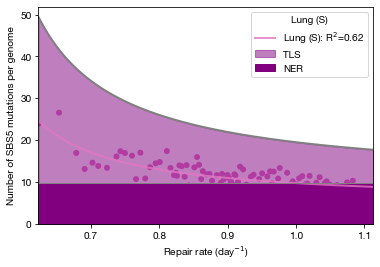

In [9]:
f,ax = plt.subplots()

plot_and_fit_curve(ax, yos,   "RepairRate", "nSBS5", "Lung (smokers)", palette["lung"])

minx = yos.RepairRate.min()
maxx = yos.RepairRate.max()
a = 4.88
b = 9.77
rmin = 0.50

xs = np.linspace(minx, maxx, 500)
ys = a / (xs - rmin) + b
ax.plot(xs, ys, lw=2, color="gray")

ax.axhline(y=b, color='gray', lw=1)

ax.fill_between(xs, ys, where=(ys > b),
                color='purple', alpha=0.5, label='TLS')

# Fill area under the curve where y <= b
ax.fill_between(xs, b,
                color='purple', label='NER')
ax.legend(title="Lung (S)")
ax.set_xlabel("Repair rate (day$^{-1}$)")
ax.set_ylabel("Number of SBS5 mutations per genome")
ax.set_ylim(bottom=0)
ax.set_xlim([minx, maxx])

Fit for nSBS5 (Neurons): a=0.00, b=1.59, r*=0.61, R2=0.01, mean(y)=1.61, NER_frac=0.99
Fit for nSBS5 (Glia): a=0.14, b=1.82, r*=0.51, R2=0.23, mean(y)=2.19, NER_frac=0.83
Fit for nSBS5 (Intestine): a=0.55, b=4.31, r*=0.53, R2=0.50, mean(y)=5.93, NER_frac=0.73
Fit for nSBS5 (Maternal): a=0.01, b=0.07, r*=0.57, R2=0.17, mean(y)=0.09, NER_frac=0.76
Fit for nSBS5 (Paternal): a=-0.01, b=0.35, r*=0.00, R2=0.00, mean(y)=0.34, NER_frac=1.02


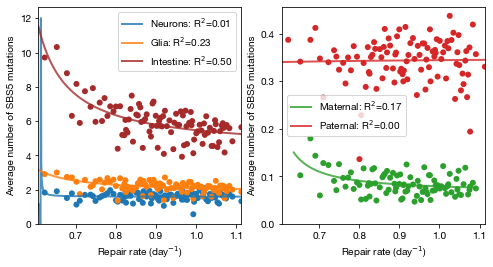

In [10]:
f,axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
plot_and_fit_curve(ax, neurons,   "RepairRate", "nSBS5", "Neurons", palette["neurons"])
plot_and_fit_curve(ax, glia,   "RepairRate", "nSBS5", "Glia", palette["glia"])
plot_and_fit_curve(ax, colon,   "RepairRate", "nSBS5", "Intestine", "brown")
ax.set_ylim(bottom=0)
ax.legend()

ax = axs[1]
plot_and_fit_curve(ax, maternal[maternal.nSBS5>0],   "RepairRate", "nSBS5", "Maternal", palette["maternal"])
plot_and_fit_curve(ax, paternal,   "RepairRate", "nSBS5", "Paternal", palette["paternal"])
ax.set_ylim(bottom=0)
ax.legend()

In [11]:
def process_study_data(study, tissue, ns_file_suffix, features_df, n_indivs):

    base_path = f"../data/{study}/"
    smoker_path = f"{base_path}{study}-signet-smokers-along.tab"
    non_smoker_path = f"{base_path}{study}-signet-{ns_file_suffix}-along.tab"
    
    smoke_df = pd.read_csv(smoker_path, sep="\t")
    non_smoke_df = pd.read_csv(non_smoker_path, sep="\t")

    smoke_df['chrid'] = smoke_df['Chr'] + smoke_df['Start'].astype(str) + smoke_df['End'].astype(str)
    non_smoke_df['chrid'] = non_smoke_df['Chr'] + non_smoke_df['Start'].astype(str) + non_smoke_df['End'].astype(str)
    
    for df in [smoke_df, non_smoke_df]:
        nsigns = [col for col in df.columns if col.startswith("nSBS")]
        df['nSBSt'] = df[nsigns].sum(axis=1)

    nsign_cols = nsigns + ['nSBSt']
    sign_burdens = pd.merge(
        smoke_df[['chrid'] + nsign_cols],
        non_smoke_df[['chrid'] + nsign_cols],
        on='chrid',
        suffixes=('_s', '_ns')
    )
    
    merged_df = pd.merge(features_df.copy(), sign_burdens, on='chrid')
    
    merged_df[f'nSBS5_s'] /= n_indivs[f'{tissue}_smoker'][1]
    merged_df[f'nSBS4_s'] /= n_indivs[f'{tissue}_smoker'][1]
    merged_df[f'nSBS5_ns'] /= n_indivs[f'{tissue}_nonsmoker'][1]
    
    return merged_df

feats = pd.read_csv("../data/features2windows/5Mb.merged.tab.gz", sep="\t", na_values=".")
feats["chrid"] = feats['chrom'] + feats['start'].astype(str) + feats['end'].astype(str)
lung = process_study_data('Yoshida2020', 'Lung', 'neversmokers', feats, n_indivs)
liver = process_study_data('Ng2021', 'Liver', 'never-smokers', feats, n_indivs)

In [12]:
dmg_cols = [
    'Hu2017-cpd_0_1',
    'Hu2017-cpd_0_2',
    'Hu2017-cpd_1440_1',
    'Hu2017-cpd_1440_2',
    'Hu2017-cpd_2160_1',
    'Hu2017-cpd_2160_2',
    'Hu2017-cpd_2880_1',
    'Hu2017-cpd_2880_2',
    'Hu2017-cpd_480_1',
    'Hu2017-cpd_480_2',
    'Hu2017-cpd_60_1',
    'Hu2017-cpd_60_2']

def fit_exp_decay(x, y0):
    y = np.log(np.array(y0) + 1)
    slope, intercept, _, _, _ = linregress(x, y)
    return intercept, slope

def infer_repair_rate(row: pd.Series, columns: list) -> float:

    times = []
    dmgs = []

    for col in columns:
        match = re.search(r'_(\d+)_', col) # Extracts time from column name
        if match:
            t = int(match.group(1))
            # Handle cases where the same time point has multiple replicates
            times.append(t)
            dmgs.append(row[col])
        else:
            print(f"Warning: Could not parse time from column: {col}")

    if not times or not dmgs or len(times) < 2:
        return np.nan # Not enough data to fit

    # Sort by time to ensure correct fitting
    sorted_indices = np.argsort(times)
    t_data = np.array(times)[sorted_indices]
    y_data = np.array(dmgs)[sorted_indices]

    _,slope = fit_exp_decay(t_data, y_data)

    return slope

lung["RepairRate"] = lung.apply(infer_repair_rate, axis=1, columns=dmg_cols) * -1 * 1440
liver["RepairRate"] = liver.apply(infer_repair_rate, axis=1, columns=dmg_cols) * -1 * 1440

Fit for nSBS5_s (Liver (S)): a=0.36, b=1.31, r*=0.43, R2=0.12, mean(y)=2.10, NER_frac=0.62
Fit for nSBS5_ns (Liver (N)): a=0.55, b=0.84, r*=0.17, R2=0.08, mean(y)=1.60, NER_frac=0.53


{'params': array([0.54723323, 0.84338608, 0.17494041]),
 'r2': 0.0764527459275951,
 'rmse': 0.45698064984875764}

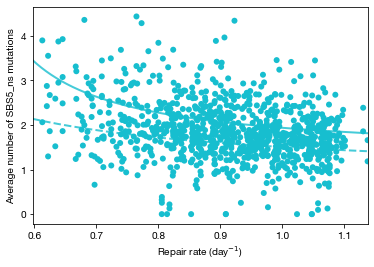

In [13]:
f,ax = plt.subplots()
plot_and_fit_curve(ax, liver,   "RepairRate", "nSBS5_s", "Liver (smokers)", palette["liver"])
plot_and_fit_curve(ax, liver,   "RepairRate", "nSBS5_ns", "Liver (non-smokers)", palette["liver"])

Fit for nSBS5_s (Lung (S)): a=1.56, b=1.42, r*=0.43, R2=0.29, mean(y)=4.92, NER_frac=0.29
Fit for nSBS5_ns (Lung (N)): a=0.47, b=0.85, r*=0.33, R2=0.18, mean(y)=1.68, NER_frac=0.50


{'params': array([0.46509182, 0.84630937, 0.32990627]),
 'r2': 0.17737936323994086,
 'rmse': 0.41704603602320517}

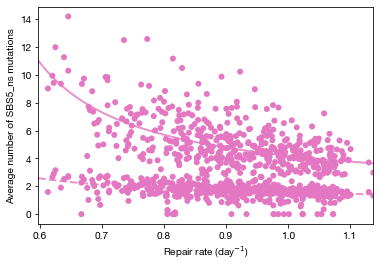

In [14]:
f,ax = plt.subplots()
plot_and_fit_curve(ax, lung,   "RepairRate", "nSBS5_s", "Lung (smokers)", palette["lung"])
plot_and_fit_curve(ax, lung,   "RepairRate", "nSBS5_ns", "Lung (non-smokers)", palette["lung"])

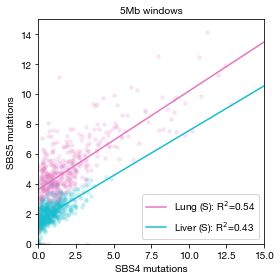

In [15]:
f, ax = plt.subplots(figsize=[4, 4])

datasets_4v5 = {
    "Lung": {"df": lung, "color": palette["lung"]},
    "Liver": {"df": liver, "color": palette["liver"]}
}

for name, props in datasets_4v5.items():

    model = smf.ols("nSBS5_s ~ nSBS4_s", data=props["df"]).fit()
    intercept, slope = model.params
    
    ax.axline(xy1=(0, intercept), slope=slope, color=props["color"], 
              label=f"{name} (S): R$^{2}$={model.rsquared:.2f}")
              
    sns.scatterplot(data=props["df"], x="nSBS4_s", y="nSBS5_s", 
                    color=props["color"], edgecolor=None, 
                    alpha=0.2, s=15, ax=ax)

ax.set_xlim([0, 15])
ax.set_ylim([0, 15])
ax.set_title("5Mb windows", fontsize=10)
ax.set_xlabel("SBS4 mutations")
ax.set_ylabel("SBS5 mutations")
ax.legend()
plt.tight_layout()

--- Partial correlation ---
Lung: Pearson R = 0.593, p-value = 5.69e-45
Liver: Pearson R = 0.574, p-value = 8.57e-42


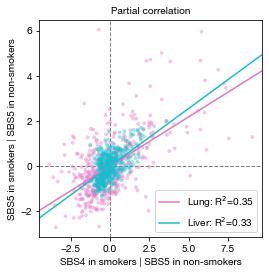

In [16]:
f, ax = plt.subplots(figsize=[4, 4])
ax.axvline(x=0, linestyle="--", lw=1, color="gray", zorder=0)
ax.axhline(y=0, linestyle="--", lw=1, color="gray", zorder=0)

datasets_pcorr = {
    "Lung": {"df": lung, "color": palette["lung"]},
    "Liver": {"df": liver, "color": palette["liver"]}
}

print("--- Partial correlation ---")

for name, props in datasets_pcorr.items():

    filtered_df = props["df"][(props["df"].nSBS5_s > 0) & 
                              (props["df"].nSBS4_s > 0) & 
                              (props["df"].nSBS5_ns > 0)]

    # Calculate the residuals of SBS4 and SBS5 after accounting for non-smoker SBS5
    x_residuals = smf.ols("nSBS4_s ~ nSBS5_ns", data=filtered_df).fit().resid
    y_residuals = smf.ols("nSBS5_s ~ nSBS5_ns", data=filtered_df).fit().resid

    resid_model = smf.ols("y ~ x", data=pd.DataFrame({'x': x_residuals, 'y': y_residuals})).fit()
    intercept, slope = resid_model.params

    ax.axline(xy1=(0, intercept), slope=slope, color=props["color"],
              label=f"{name}: R$^{2}$={resid_model.rsquared:.2f}")
              
    ax.scatter(x_residuals, y_residuals, alpha=0.4, edgecolor="none",
               color=props["color"], s=15)

    p_corr = stats.pearsonr(x_residuals, y_residuals)
    print(f"{name}: Pearson R = {p_corr[0]:.3f}, p-value = {p_corr[1]:.3g}")

ax.set_xlabel("SBS4 in smokers | SBS5 in non-smokers")
ax.set_ylabel("SBS5 in smokers | SBS5 in non-smokers")
ax.set_title("Partial correlation", fontsize=10)
ax.legend()

In [17]:
def estimate_ner_tls(df, x_col, y_col):

    xs = df[x_col].values
    ys = df[y_col].values

    rmin_upper_bound = np.min(xs)
    lower_bounds = [-np.inf, 0, 0]
    upper_bounds = [np.inf, np.inf, rmin_upper_bound]
    initial_guesses = [1.0, np.min(ys), 0]

    popt, _ = curve_fit(
        mod_hyperbolic_model, xs, ys,
        p0=initial_guesses,
        bounds=(lower_bounds, upper_bounds),
        maxfev=5000
    )
    a_fit, b_fit, rmin_fit = popt

    sigs = [c for c in df.columns if c.startswith("nSBS")]
    with open("sbs_dna_damage.txt", "r") as fh:
        eti = {l.split()[0]:" ".join(l.split("\t")[1:]).strip() for l in fh.readlines()}
        dmgs = ["n"+k for k in eti.keys()]

    sig_counts = df[sigs].sum().to_dict()
    total = sum(sig_counts.values())
    sbs5 = sig_counts["nSBS5"] / total
    dmg = sum([sig_counts[dmg] for dmg in dmgs if dmg in sig_counts]) / total
    ner = (b_fit / np.mean(ys)) * sbs5
    tls = (1 - (b_fit / np.mean(ys))) * sbs5
    if ner<0: ner=0
    if tls<0: tls=0
    return [ner, tls, sbs5, dmg, total]

props_l = [
    estimate_ner_tls(yos,   "RepairRate", "nSBS5"),
    estimate_ner_tls(yosns, "RepairRate", "nSBS5"),
    estimate_ner_tls(ng,   "RepairRate", "nSBS5"),
    estimate_ner_tls(ngns, "RepairRate", "nSBS5"),
    estimate_ner_tls(colon,   "RepairRate", "nSBS5"),
    estimate_ner_tls(maternal,   "RepairRate", "nSBS5"),
    estimate_ner_tls(paternal, "RepairRate", "nSBS5"),
    estimate_ner_tls(neurons,   "RepairRate", "nSBS5"),
    estimate_ner_tls(glia, "RepairRate", "nSBS5"),
]
props = pd.DataFrame(props_l)
props.columns = ["ner", "tls", "sbs5", "dmg", "total"]
props["ctype"] = ["Lung (S)", "Lung (NS)", "Liver (S)", "Liver (NS)", "Intestine",
                  "Maternal", "Paternal", "Neurons", "Glia"]

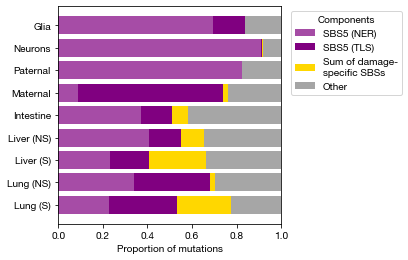

In [18]:
f,ax = plt.subplots(figsize=[4,4])
start_tls = props['ner']
start_dmg = props['ner'] + props['tls']
start_gray = props['ner'] + props['tls'] + props['dmg']

ax.barh(props.index, props['ner'], color='purple', label='SBS5 (NER)', alpha=0.7)
ax.barh(props.index, props['tls'], left=start_tls, color='purple', label='SBS5 (TLS)')
ax.barh(props.index, props['dmg'], left=start_dmg, color='gold', label='Sum of damage-\nspecific SBSs')
ax.barh(props.index, 1 - start_gray, left=start_gray, color='gray', label='Other', alpha=0.7)

ax.legend(title='Components', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_yticks(range(len(props.ctype)))
ax.set_yticklabels(list(props.ctype))
ax.set_xlabel("Proportion of mutations")
ax.set_xlim([0,1])
plt.show()

In [19]:
dist = pd.read_table("clusters-distances.tab")
dist.columns = ["distance", "neurons", "glia", "maternal", "paternal", 
                "lung_s", "lung_ns", "liver_s", "liver_ns"]
ctypes = dist.columns[1:]
sdist = dist.sort_values(by="distance", ascending=False).reset_index(drop=True)
cdist = sdist[ctypes].cumsum()
cdist["distance"] = sdist.distance

significance -2.995732273553991


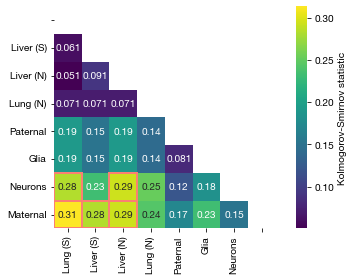

In [20]:
from scipy.stats import ks_2samp
import itertools
import matplotlib.patches as patches

ks_l = []
for c1,c2 in list(itertools.permutations(cdist.columns[:-1], r=2)):
    k = ks_2samp(cdist[c1], cdist[c2])
    ks_l.append([c1,c2,np.log10(k[1]), k[0]])
ks = pd.DataFrame(ks_l)
ks.columns = ["c1", "c2", "pval", "ks"]

p_sq = ks.pivot(columns="c1", index="c2", values="pval")
d_sq = ks.pivot(columns="c1", index="c2", values="ks")
mask = np.triu(np.ones_like(p_sq, dtype=bool))
th = np.log(0.05)
print("significance", th)

order = ["lung_s", "liver_s", "liver_ns", "lung_ns", "paternal", "glia", "neurons", "maternal"]
p_sq = p_sq[order].loc[order]
d_sq = d_sq[order].loc[order]
g = sns.heatmap(d_sq, mask=mask, cbar_kws={'label': 'Kolmogorov-Smirnov statistic'}, 
                cmap="viridis", annot=True, square=True) 
g.set_xticklabels([s.capitalize().replace("_s", " (S)").replace("_ns", " (N)") for s in order][:-1] + [""])
g.set_yticklabels([""] + [s.capitalize().replace("_s", " (S)").replace("_ns", " (N)") for s in order][1:])
g.set_xlabel("")
g.set_ylabel("")

for i in range(p_sq.shape[0]):
    for j in range(p_sq.shape[1]):
        if not mask[i, j] and p_sq.iloc[i, j] < th:
            g.add_patch(
                patches.Rectangle(
                    (j, i),       
                    1,            
                    1,            
                    fill=False,
                    edgecolor='salmon',
                    zorder = 10,
                    lw=2          
                )
            )
plt.tight_layout()
plt.savefig("sup_pdfs/ks_ccdfs.pdf")

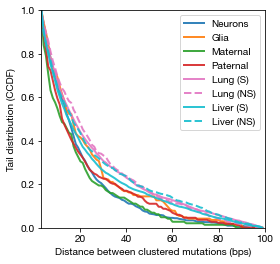

In [21]:
f,ax = plt.subplots(figsize=[4,4])
for ctype in dist.columns[1:]:
#    if ctype not in ["maternal", "glia"]: continue
    label = ctype.capitalize().replace("_ns", " (NS)").replace("_s", " (S)")
    ax.plot(cdist["distance"], cdist[ctype], 
            label=label, ls = "--" if "_ns" in ctype else "-",
            color=palette[ctype.split("_")[0]], alpha=0.9, lw=2)
ax.set_xlim([3, 100])
ax.set_ylim([0,1])
ax.set_xlabel("Distance between clustered mutations (bps)")
ax.set_ylabel("Tail distribution (CCDF)")
ax.legend()

In [22]:
csign = pd.read_table("clusters-signet.tab")
csign["Fraction"] = csign["Fraction"]*2
csign["fSBS5_40"] = csign.Fraction * csign["SBS5/40"]
csign["fSBS4"] = csign.Fraction * csign["SBS4"]

In [23]:
csign.set_index("Tissue_CellType")["Fraction"]

Tissue_CellType
Liver_never-smoker    0.005744
Liver_smoker          0.006198
Lung_never-smoker     0.006430
Lung_smoker           0.007295
Maternal              0.006161
Neuron                0.007592
Oligo                 0.005459
Paternal              0.003194
Name: Fraction, dtype: float64

In [24]:
csign.set_index("Tissue_CellType")["fSBS4"] / csign.set_index("Tissue_CellType")["Fraction"]

Tissue_CellType
Liver_never-smoker    0.000000
Liver_smoker          0.105320
Lung_never-smoker     0.000000
Lung_smoker           0.122358
Maternal              0.000000
Neuron                0.000000
Oligo                 0.000000
Paternal              0.000000
dtype: float64

In [25]:
csign.set_index("Tissue_CellType")["fSBS5_40"] / csign.set_index("Tissue_CellType")["Fraction"]

Tissue_CellType
Liver_never-smoker    0.758530
Liver_smoker          0.222616
Lung_never-smoker     0.456731
Lung_smoker           0.649983
Maternal              0.000000
Neuron                0.000000
Oligo                 0.000000
Paternal              0.911843
dtype: float64

[Text(0, 0, 'Paternal'),
 Text(0, 1, 'Maternal'),
 Text(0, 2, 'Glia'),
 Text(0, 3, 'Neuron'),
 Text(0, 4, 'Liver (NS)'),
 Text(0, 5, 'Liver (S)'),
 Text(0, 6, 'Lung (NS)'),
 Text(0, 7, 'Lung (S)')]

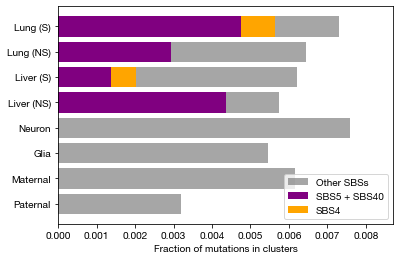

In [26]:
f,ax = plt.subplots()

otypes = ["Paternal", "Maternal", "Oligo", "Neuron", 
          "Liver_never-smoker", "Liver_smoker", 
          "Lung_never-smoker", "Lung_smoker"]
labels = []

for i,ctype in enumerate(otypes):
    label = ctype.replace("Oligo", "Glia").replace("_never-smoker", " (NS)").replace("_smoker", " (S)")
    labels.append(label)
    r = csign[csign.Tissue_CellType==ctype]
    ax.barh(i, r.Fraction, color="gray", alpha=0.7,
            label="Other SBSs" if ctype=="Lung_smoker" else "")
    if "_" in ctype:
        ax.barh(i, r.fSBS5_40, color="purple", 
                 label="SBS5 + SBS40" if ctype=="Lung_smoker" else "")
        ax.barh(i, r.fSBS4, left=r.fSBS5_40, color="orange", 
                 label="SBS4" if ctype=="Lung_smoker" else "")

ax.set_xlabel("Fraction of mutations in clusters")
ax.set_xlim([0, 0.0087])
ax.legend()
ax.set_yticks(range(len(otypes)))
ax.set_yticklabels(labels)


In [27]:
def plot_loess(ax, data, x_col, y_col, frac=0.5, **kwargs):

    subset = data[[x_col, y_col]].dropna()
    
    smoothed = sm.nonparametric.lowess(
        endog=subset[y_col], 
        exog=subset[x_col], 
        frac=frac
    )

    ax.plot(smoothed[:, 0], smoothed[:, 1], **kwargs)

assy = pd.read_table("clusters-distancesCA.tab")
assy.columns = ["distance", "liver", "lung"]
neg = assy[assy.distance<0].dropna()
pos = assy[assy.distance>0].dropna()

Text(0.5, 0, 'Distance from SBS4-like (C:G > A:T) mutation')

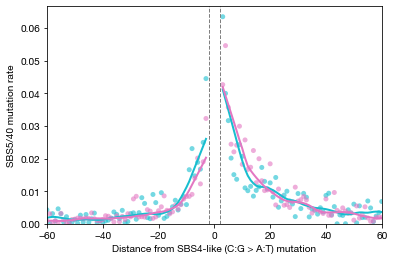

In [28]:
f,ax = plt.subplots()

sz = 25
a = 0.6
frac = 0.15
lw = 2

c = palette["liver"]
plot_loess(ax, neg, "distance", "liver", frac=frac, lw=lw, color=c)
ax.scatter(neg.distance, neg.liver, s=sz, color=c, alpha=a, edgecolor="none")

plot_loess(ax, pos, "distance", "liver", frac=frac, lw=lw, color=c)
ax.scatter(pos.distance, pos.liver, s=sz, color=c, alpha=a, edgecolor="none")

c = palette["lung"]
plot_loess(ax, neg, "distance", "lung", frac=frac, lw=lw, color=c)
ax.scatter(neg.distance, neg.lung, s=sz, color=c, alpha=a, edgecolor="none")

plot_loess(ax, pos, "distance", "lung", frac=frac, lw=lw, color=c)
ax.scatter(pos.distance, pos.lung, s=sz, color=c, alpha=a, edgecolor="none")

ax.axvline(x=2, lw=1, color="gray", ls="--")
ax.axvline(x=-2, lw=1, color="gray", ls="--")
ax.set_ylim(bottom=0)
ax.set_xlim([-60, 60])
ax.set_ylabel("SBS5/40 mutation rate")
ax.set_xlabel("Distance from SBS4-like (C:G > A:T) mutation")

Lung: Pearson R = 0.593, p-value = 5.69e-45
Liver: Pearson R = 0.574, p-value = 8.57e-42
Fit for Yoshida2020-clustersCA (Lung (S)): a=0.02, b=0.00, r*=0.55, R2=0.54, mean(y)=0.06, NER_frac=0.00
Fit for Ng2021-clustersCA (Liver (S)): a=0.01, b=0.00, r*=0.48, R2=0.42, mean(y)=0.02, NER_frac=0.06
Fit for nSBS4 (Lung (S)): a=1.43, b=0.00, r*=0.58, R2=0.67, mean(y)=4.88, NER_frac=0.00
Fit for nSBS4 (Liver (S)): a=0.70, b=0.00, r*=0.56, R2=0.68, mean(y)=2.27, NER_frac=0.00
Fit for nSBS5 (Lung (S)): a=2.44, b=4.89, r*=0.50, R2=0.62, mean(y)=11.40, NER_frac=0.43
Fit for nSBS5 (Lung (N)): a=0.77, b=1.67, r*=0.42, R2=0.38, mean(y)=3.35, NER_frac=0.50
Fit for nSBS5 (Liver (S)): a=0.57, b=2.38, r*=0.55, R2=0.56, mean(y)=4.18, NER_frac=0.57
Fit for nSBS5 (Liver (N)): a=0.26, b=2.29, r*=0.54, R2=0.18, mean(y)=3.10, NER_frac=0.74
Fit for nSBS5 (Colon): a=0.55, b=4.31, r*=0.53, R2=0.50, mean(y)=5.93, NER_frac=0.73
Fit for nSBS5 (Neurons): a=0.00, b=1.59, r*=0.61, R2=0.01, mean(y)=1.61, NER_frac=0.99
F

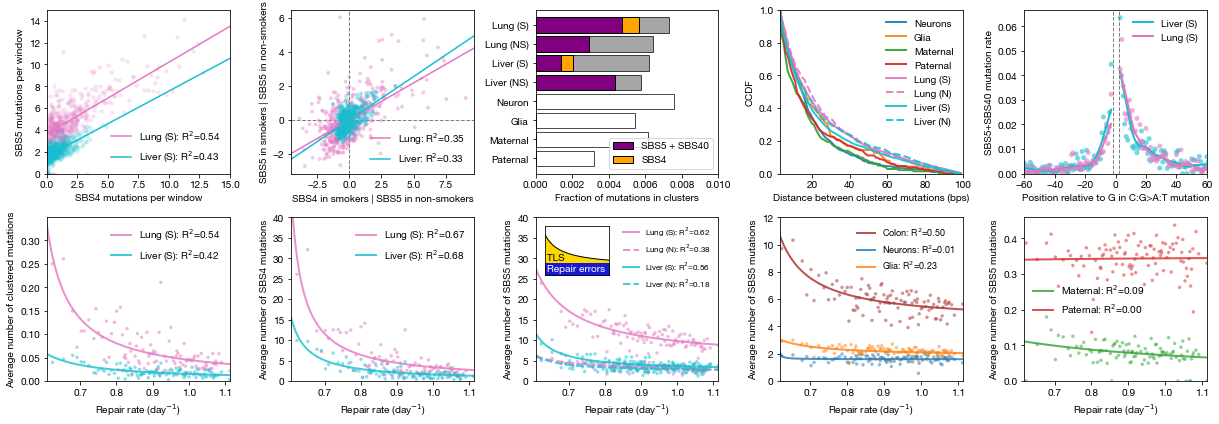

In [35]:
# Configuration
plt.rcParams["font.family"] = "Helvetica Neue"
mosaic = '''
ABCDE
FGHIJ
'''
fig, axs = plt.subplot_mosaic(mosaic, figsize=[17,6])

### 4 vs 5 scatter
ax = axs["A"]
for name, props in datasets_4v5.items():

    model = smf.ols("nSBS5_s ~ nSBS4_s", data=props["df"]).fit()
    intercept, slope = model.params
    
    ax.axline(xy1=(0, intercept), slope=slope, color=props["color"], 
              label=f"{name} (S): R$^{2}$={model.rsquared:.2f}")
              
    sns.scatterplot(data=props["df"], x="nSBS4_s", y="nSBS5_s", 
                    color=props["color"], edgecolor=None, 
                    alpha=0.2, s=15, ax=ax)

ax.set_xlim([0, 15])
ax.set_ylim([0, 15])
#ax.set_title("5Mb windows", fontsize=10)
ax.set_xlabel("SBS4 mutations per window")
ax.set_ylabel("SBS5 mutations per window")
ax.legend(frameon=False)

### Partial correlations
ax = axs["B"]
ax.axvline(x=0, linestyle="--", lw=1, color="gray", zorder=0)
ax.axhline(y=0, linestyle="--", lw=1, color="gray", zorder=0)
for name, props in datasets_pcorr.items():

    filtered_df = props["df"][(props["df"].nSBS5_s > 0) & 
                              (props["df"].nSBS4_s > 0) & 
                              (props["df"].nSBS5_ns > 0)]

    # Calculate the residuals of SBS4 and SBS5 after accounting for non-smoker SBS5
    x_residuals = smf.ols("nSBS4_s ~ nSBS5_ns", data=filtered_df).fit().resid
    y_residuals = smf.ols("nSBS5_s ~ nSBS5_ns", data=filtered_df).fit().resid

    resid_model = smf.ols("y ~ x", data=pd.DataFrame({'x': x_residuals, 'y': y_residuals})).fit()
    intercept, slope = resid_model.params

    ax.axline(xy1=(0, intercept), slope=slope, color=props["color"],
              label=f"{name}: R$^{2}$={resid_model.rsquared:.2f}")
              
    ax.scatter(x_residuals, y_residuals, alpha=0.4, edgecolor="none",
               color=props["color"], s=15)

    p_corr = stats.pearsonr(x_residuals, y_residuals)
    print(f"{name}: Pearson R = {p_corr[0]:.3f}, p-value = {p_corr[1]:.3g}")

ax.set_xlabel("SBS4 in smokers | SBS5 in non-smokers")
ax.set_ylabel("SBS5 in smokers | SBS5 in non-smokers")
#ax.set_title("Partial correlation", fontsize=10)
ax.legend(frameon=False, loc="lower right")


### Cluster proportions
ax = axs["C"]
otypes = ["Paternal", "Maternal", "Oligo", "Neuron", 
          "Liver_never-smoker", "Liver_smoker", 
          "Lung_never-smoker", "Lung_smoker"]
labels = []

for i,ctype in enumerate(otypes):
    label = ctype.replace("Oligo", "Glia").replace("_never-smoker", " (NS)").replace("_smoker", " (S)")
    labels.append(label)
    r = csign[csign.Tissue_CellType==ctype]
    ax.barh(i, r.Fraction, color="gray" if "_" in ctype else "none", 
            edgecolor="black",
            alpha=0.7,
            label="" if ctype=="Lung_smoker" else "")
    if "_" in ctype:
        ax.barh(i, r.fSBS5_40, color="purple", 
                edgecolor="black",
                label="SBS5 + SBS40" if ctype=="Lung_smoker" else "")
        ax.barh(i, r.fSBS4, left=r.fSBS5_40, color="orange", 
                edgecolor="black",
                label="SBS4" if ctype=="Lung_smoker" else "")

ax.set_xlabel("Fraction of mutations in clusters")
ax.set_xlim([0, 0.01])
ax.legend()
ax.set_yticks(range(len(otypes)))
ax.set_yticklabels(labels)

### Distance distribution
ax = axs["D"]
for ctype in dist.columns[1:]:
    label = ctype.capitalize().replace("_ns", " (N)").replace("_s", " (S)")
    ax.plot(cdist["distance"], cdist[ctype], 
            label=label, ls = "--" if "_ns" in ctype else "-",
            color=palette[ctype.split("_")[0]], alpha=0.9, lw=2)
ax.set_xlim([3, 100])
ax.set_ylim([0,1])
ax.set_xlabel("Distance between clustered mutations (bps)")
ax.set_ylabel("CCDF")
ax.legend(frameon=False)

### Replication direction
ax = axs["E"]
sz = 25
a = 0.6
frac = 0.15
lw = 2

c = palette["liver"]
plot_loess(ax, neg, "distance", "liver", frac=frac, lw=lw, color=c)
ax.scatter(neg.distance, neg.liver, s=sz, color=c, alpha=a, edgecolor="none")

plot_loess(ax, pos, "distance", "liver", frac=frac, lw=lw, color=c, label = "Liver (S)")
ax.scatter(pos.distance, pos.liver, s=sz, color=c, alpha=a, edgecolor="none")

c = palette["lung"]
plot_loess(ax, neg, "distance", "lung", frac=frac, lw=lw, color=c)
ax.scatter(neg.distance, neg.lung, s=sz, color=c, alpha=a, edgecolor="none")

plot_loess(ax, pos, "distance", "lung", frac=frac, lw=lw, color=c, label="Lung (S)")
ax.scatter(pos.distance, pos.lung, s=sz, color=c, alpha=a, edgecolor="none")

ax.legend(frameon=False)
ax.axvline(x=2, lw=1, color="gray", ls="--")
ax.axvline(x=-2, lw=1, color="gray", ls="--")
ax.set_ylim(bottom=0)
ax.set_xlim([-60, 60])
ax.set_ylabel("SBS5+SBS40 mutation rate")
ax.set_xlabel("Position relative to G in C:G>A:T mutation")

### vs repair in multiple cell lines
sz = 12
a = 0.5

### vs repair in lung and liver

ax = axs["F"]
plot_and_fit_curve(ax, yos,   "RepairRate", "Yoshida2020-clustersCA", "Lung (smokers)", palette["lung"], s=sz, alpha=a)
plot_and_fit_curve(ax, ng,   "RepairRate", "Ng2021-clustersCA", "Liver (smokers)", palette["liver"], s=sz, alpha=a)
ax.set_ylim(bottom=0)
#ax.set_title("Mutation clusters in percentiles of NER rates", fontsize=10)
ax.legend(frameon=False)

ax = axs["G"]
plot_and_fit_curve(ax, yos,   "RepairRate", "nSBS4", "Lung (smokers)", palette["lung"], s=sz, alpha=a)
plot_and_fit_curve(ax, ng,   "RepairRate", "nSBS4", "Liver (smokers)", palette["liver"], s=sz, alpha=a)
ax.set_ylim([0, 40])
#ax.set_title("SBS4 mutations in percentiles of NER rates", fontsize=10)
ax.legend(frameon=False)

ax = axs["H"]
plot_and_fit_curve(ax, yos,   "RepairRate", "nSBS5", "Lung (smokers)", palette["lung"], s=sz, alpha=a)
plot_and_fit_curve(ax, yosns, "RepairRate", "nSBS5", "Lung (non-smokers)", palette["lung"], s=sz, alpha=a)
plot_and_fit_curve(ax, ng,    "RepairRate", "nSBS5", "Liver (smokers)", palette["liver"], s=sz, alpha=a)
plot_and_fit_curve(ax, ngns,  "RepairRate", "nSBS5", "Liver (non-smokers)", palette["liver"], s=sz, alpha=a)
ax.set_ylim([0, 40])
#ax.set_title("SBS5 mutations in percentiles of NER rates", fontsize=10)
ax.legend(fontsize=8, frameon=False)

### Inset
inset_ax = ax.inset_axes([0.05, 0.65, 0.35, 0.3]) # [x, y, width, height]
minx = yos.RepairRate.min()
maxx = yos.RepairRate.max()
s = 4.88
b = 9.77
rmin = 0.50

xs = np.linspace(minx, maxx, 500)
ys = s / (xs - rmin) + b
inset_ax.plot(xs, ys, lw=1, color="black")

#inset_ax.axhline(y=14, color='gray', lw=1)

inset_ax.fill_between(xs, ys, where=(ys > b),
                      color='#FFD800', label='TLS')
inset_ax.fill_between(xs, 14,
                      color='#1919D2', label='NER')

#inset_ax.legend(title="Lung (S)", fontsize=8, title_fontsize=9)
inset_ax.set_xlabel("", fontsize=8)
inset_ax.set_ylabel("", fontsize=8)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.annotate("Repair errors", xy=(0.03, 0.12), color="white",
                  xycoords="axes fraction", ha="left", va="center")
inset_ax.annotate("TLS", xy=(0.03, 0.35), 
                  xycoords="axes fraction", ha="left", va="center")
inset_ax.set_ylim([0, 60])
inset_ax.set_xlim([minx, maxx])
inset_ax.tick_params(axis='both', which='major', labelsize=8)

ax = axs["I"]
plot_and_fit_curve(ax, colon,   "RepairRate", "nSBS5", "Colon", "brown", s=sz, alpha=a)
plot_and_fit_curve(ax, neurons,   "RepairRate", "nSBS5", "Neurons", palette["neurons"], s=sz, alpha=a)
plot_and_fit_curve(ax, glia,   "RepairRate", "nSBS5", "Glia", palette["glia"], s=sz, alpha=a)
ax.set_xlim(left=neurons.RepairRate.min()-0.005)
ax.set_ylim([0, 12])
ax.legend(frameon=False, loc="upper right", fontsize=9)

ax = axs["J"]
plot_and_fit_curve(ax, maternal,   "RepairRate", "nSBS5", "Maternal", palette["maternal"], s=sz, alpha=a)
plot_and_fit_curve(ax, paternal,   "RepairRate", "nSBS5", "Paternal", palette["paternal"], s=sz, alpha=a)
ax.set_xlim(left=neurons.RepairRate.min()-0.005)
ax.set_ylim(bottom=0)
#ax.set_title("SBS5 mutations in percentiles of NER rates", fontsize=10)
ax.legend(frameon=False)

plt.tight_layout()
plt.savefig("pdfs/fig4.pdf")
plt.savefig("pdfs/fig4.jpg", dpi=400)

Lung: Pearson R = 0.593, p-value = 5.69e-45
Liver: Pearson R = 0.574, p-value = 8.57e-42
Fit for Yoshida2020-clustersCA (Lung (S)): a=0.02, b=0.00, r*=0.55, R2=0.54, mean(y)=0.06, NER_frac=0.00
Fit for Ng2021-clustersCA (Liver (S)): a=0.01, b=0.00, r*=0.48, R2=0.42, mean(y)=0.02, NER_frac=0.06
Fit for nSBS4 (Lung (S)): a=2.86, b=0.00, r*=0.58, R2=0.67, mean(y)=9.76, NER_frac=0.00
Fit for nSBS4 (Liver (S)): a=1.39, b=0.00, r*=0.56, R2=0.68, mean(y)=4.53, NER_frac=0.00
Fit for nSBS5 (Lung (S)): a=4.88, b=9.77, r*=0.50, R2=0.62, mean(y)=22.80, NER_frac=0.43
Fit for nSBS5 (Lung (NS)): a=1.54, b=3.34, r*=0.42, R2=0.38, mean(y)=6.70, NER_frac=0.50
Fit for nSBS5 (Liver (S)): a=1.14, b=4.76, r*=0.55, R2=0.56, mean(y)=8.35, NER_frac=0.57
Fit for nSBS5 (Liver (NS)): a=0.52, b=4.59, r*=0.54, R2=0.18, mean(y)=6.20, NER_frac=0.74
Fit for nSBS5 (Neurons): a=0.00, b=3.19, r*=0.61, R2=0.01, mean(y)=3.21, NER_frac=0.99
Fit for nSBS5 (Glia): a=0.27, b=3.64, r*=0.51, R2=0.23, mean(y)=4.38, NER_frac=0.83


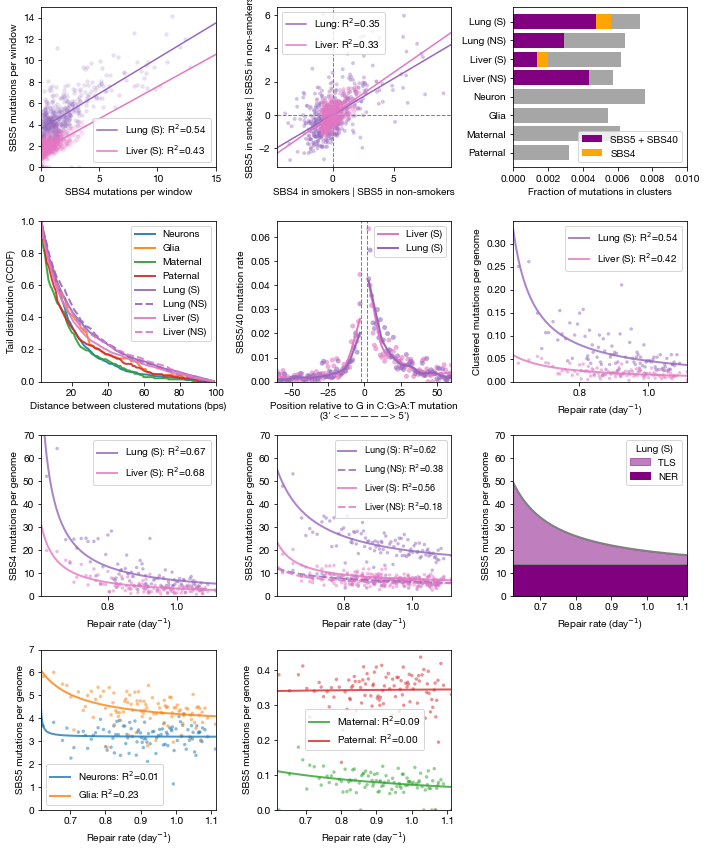

In [41]:
# Configuration
plt.rcParams["font.family"] = "Helvetica Neue"
mosaic = '''
ABC
DEF
GHI
JKL
'''
fig, axs = plt.subplot_mosaic(mosaic, figsize=[10,12])

### 4 vs 5 scatter
ax = axs["A"]
for name, props in datasets_4v5.items():

    model = smf.ols("nSBS5_s ~ nSBS4_s", data=props["df"]).fit()
    intercept, slope = model.params
    
    ax.axline(xy1=(0, intercept), slope=slope, color=props["color"], 
              label=f"{name} (S): R$^{2}$={model.rsquared:.2f}")
              
    sns.scatterplot(data=props["df"], x="nSBS4_s", y="nSBS5_s", 
                    color=props["color"], edgecolor=None, 
                    alpha=0.2, s=15, ax=ax)

ax.set_xlim([0, 15])
ax.set_ylim([0, 15])
#ax.set_title("5Mb windows", fontsize=10)
ax.set_xlabel("SBS4 mutations per window")
ax.set_ylabel("SBS5 mutations per window")
ax.legend()

### Partial correlations
ax = axs["B"]
ax.axvline(x=0, linestyle="--", lw=1, color="gray", zorder=0)
ax.axhline(y=0, linestyle="--", lw=1, color="gray", zorder=0)
for name, props in datasets_pcorr.items():

    filtered_df = props["df"][(props["df"].nSBS5_s > 0) & 
                              (props["df"].nSBS4_s > 0) & 
                              (props["df"].nSBS5_ns > 0)]

    # Calculate the residuals of SBS4 and SBS5 after accounting for non-smoker SBS5
    x_residuals = smf.ols("nSBS4_s ~ nSBS5_ns", data=filtered_df).fit().resid
    y_residuals = smf.ols("nSBS5_s ~ nSBS5_ns", data=filtered_df).fit().resid

    resid_model = smf.ols("y ~ x", data=pd.DataFrame({'x': x_residuals, 'y': y_residuals})).fit()
    intercept, slope = resid_model.params

    ax.axline(xy1=(0, intercept), slope=slope, color=props["color"],
              label=f"{name}: R$^{2}$={resid_model.rsquared:.2f}")
              
    ax.scatter(x_residuals, y_residuals, alpha=0.4, edgecolor="none",
               color=props["color"], s=15)

    p_corr = stats.pearsonr(x_residuals, y_residuals)
    print(f"{name}: Pearson R = {p_corr[0]:.3f}, p-value = {p_corr[1]:.3g}")

ax.set_xlabel("SBS4 in smokers | SBS5 in non-smokers")
ax.set_ylabel("SBS5 in smokers | SBS5 in non-smokers")
#ax.set_title("Partial correlation", fontsize=10)
ax.legend()




### Cluster proportions
ax = axs["C"]
otypes = ["Paternal", "Maternal", "Oligo", "Neuron", 
          "Liver_never-smoker", "Liver_smoker", 
          "Lung_never-smoker", "Lung_smoker"]
labels = []

for i,ctype in enumerate(otypes):
    label = ctype.replace("Oligo", "Glia").replace("_never-smoker", " (NS)").replace("_smoker", " (S)")
    labels.append(label)
    r = csign[csign.Tissue_CellType==ctype]
    ax.barh(i, r.Fraction, color="gray", alpha=0.7,
            label="" if ctype=="Lung_smoker" else "")
    if "_" in ctype:
        ax.barh(i, r.fSBS5_40, color="purple", 
                label="SBS5 + SBS40" if ctype=="Lung_smoker" else "")
        ax.barh(i, r.fSBS4, left=r.fSBS5_40, color="orange", 
                label="SBS4" if ctype=="Lung_smoker" else "")

ax.set_xlabel("Fraction of mutations in clusters")
ax.set_xlim([0, 0.01])
ax.legend()
ax.set_yticks(range(len(otypes)))
ax.set_yticklabels(labels)

### Distance distribution
ax = axs["D"]
for ctype in dist.columns[1:]:
    label = ctype.capitalize().replace("_ns", " (NS)").replace("_s", " (S)")
    ax.plot(cdist["distance"], cdist[ctype], 
            label=label, ls = "--" if "_ns" in ctype else "-",
            color=palette[ctype.split("_")[0]], alpha=0.9, lw=2)
ax.set_xlim([3, 100])
ax.set_ylim([0,1])
ax.set_xlabel("Distance between clustered mutations (bps)")
ax.set_ylabel("Tail distribution (CCDF)")
ax.legend()

### Replication direction
ax = axs["E"]
sz = 25
a = 0.6
frac = 0.15
lw = 2

c = palette["liver"]
plot_loess(ax, neg, "distance", "liver", frac=frac, lw=lw, color=c)
ax.scatter(neg.distance, neg.liver, s=sz, color=c, alpha=a, edgecolor="none")

plot_loess(ax, pos, "distance", "liver", frac=frac, lw=lw, color=c, label = "Liver (S)")
ax.scatter(pos.distance, pos.liver, s=sz, color=c, alpha=a, edgecolor="none")

c = palette["lung"]
plot_loess(ax, neg, "distance", "lung", frac=frac, lw=lw, color=c)
ax.scatter(neg.distance, neg.lung, s=sz, color=c, alpha=a, edgecolor="none")

plot_loess(ax, pos, "distance", "lung", frac=frac, lw=lw, color=c, label="Lung (S)")
ax.scatter(pos.distance, pos.lung, s=sz, color=c, alpha=a, edgecolor="none")

ax.legend()
ax.axvline(x=2, lw=1, color="gray", ls="--")
ax.axvline(x=-2, lw=1, color="gray", ls="--")
ax.set_ylim(bottom=0)
ax.set_xlim([-60, 60])
ax.set_ylabel("SBS5/40 mutation rate")
ax.set_xlabel("Position relative to G in C:G>A:T mutation\n(3' <—————> 5')")

### vs repair in multiple cell lines
sz = 12
a = 0.5

### vs repair in lung and liver

ax = axs["F"]
plot_and_fit_curve(ax, yos,   "RepairRate", "Yoshida2020-clustersCA", "Lung (smokers)", palette["lung"], s=sz, alpha=a)
plot_and_fit_curve(ax, ng,   "RepairRate", "Ng2021-clustersCA", "Liver (smokers)", palette["liver"], s=sz, alpha=a)
ax.set_ylim(bottom=0)
#ax.set_title("Mutation clusters in percentiles of NER rates", fontsize=10)
ax.legend()

ax = axs["G"]
plot_and_fit_curve(ax, yos,   "RepairRate", "nSBS4", "Lung (smokers)", palette["lung"], s=sz, alpha=a)
plot_and_fit_curve(ax, ng,   "RepairRate", "nSBS4", "Liver (smokers)", palette["liver"], s=sz, alpha=a)
ax.set_ylim([0, 70])
#ax.set_title("SBS4 mutations in percentiles of NER rates", fontsize=10)
ax.legend()

ax = axs["H"]
plot_and_fit_curve(ax, yos,   "RepairRate", "nSBS5", "Lung (smokers)", palette["lung"], s=sz, alpha=a)
plot_and_fit_curve(ax, yosns, "RepairRate", "nSBS5", "Lung (non-smokers)", palette["lung"], s=sz, alpha=a)
plot_and_fit_curve(ax, ng,    "RepairRate", "nSBS5", "Liver (smokers)", palette["liver"], s=sz, alpha=a)
plot_and_fit_curve(ax, ngns,  "RepairRate", "nSBS5", "Liver (non-smokers)", palette["liver"], s=sz, alpha=a)
ax.set_ylim([0, 70])
#ax.set_title("SBS5 mutations in percentiles of NER rates", fontsize=10)
ax.legend(fontsize=9)

ax = axs["I"]
minx = yos.RepairRate.min()
maxx = yos.RepairRate.max()
s = 4.88
b = 9.77
rmin = 0.50

xs = np.linspace(minx, maxx, 500)
ys = s / (xs - rmin) + b
ax.plot(xs, ys, lw=2, color="gray")

ax.axhline(y=14, color='gray', lw=1)

ax.fill_between(xs, ys, where=(ys > b),
                color='purple', alpha=0.5, label='TLS')
ax.fill_between(xs, 14,
                color='purple', label='NER')
ax.legend(title="Lung (S)")
ax.set_xlabel("Repair rate (day$^{-1}$)")
ax.set_ylabel("SBS5 mutations per genome")
ax.set_ylim([0, 70])
ax.set_xlim([minx, maxx])

ax = axs["J"]
plot_and_fit_curve(ax, neurons,   "RepairRate", "nSBS5", "Neurons", palette["neurons"], s=sz, alpha=a)
plot_and_fit_curve(ax, glia,   "RepairRate", "nSBS5", "Glia", palette["glia"], s=sz, alpha=a)
ax.set_xlim(left=neurons.RepairRate.min()-0.005)
ax.set_ylim([0,7])
ax.legend()

ax = axs["K"]
plot_and_fit_curve(ax, maternal,   "RepairRate", "nSBS5", "Maternal", palette["maternal"], s=sz, alpha=a)
plot_and_fit_curve(ax, paternal,   "RepairRate", "nSBS5", "Paternal", palette["paternal"], s=sz, alpha=a)
ax.set_xlim(left=neurons.RepairRate.min()-0.005)
ax.set_ylim(bottom=0)
#ax.set_title("SBS5 mutations in percentiles of NER rates", fontsize=10)
ax.legend()

ax = axs["L"]
ax.axis('off')

plt.tight_layout()
#plt.savefig("pdfs/fig4.pdf")
plt.savefig("pdfs/fig4.jpg", dpi=400)

Fit for nSBS5 (SBS5 (S)): a=4.88, b=9.77, r*=0.50, R2=0.62, mean(y)=22.80, NER_frac=0.43
Fit for nSBS5 (SBS5 (NS)): a=1.54, b=3.34, r*=0.42, R2=0.38, mean(y)=6.70, NER_frac=0.50
Fit for nSBS4 (SBS4 (S)): a=2.86, b=0.00, r*=0.58, R2=0.67, mean(y)=9.76, NER_frac=0.00
Fit for nSBS5 (SBS5 (S)): a=1.14, b=4.76, r*=0.55, R2=0.56, mean(y)=8.35, NER_frac=0.57
Fit for nSBS5 (SBS5 (NS)): a=0.52, b=4.59, r*=0.54, R2=0.18, mean(y)=6.20, NER_frac=0.74
Fit for nSBS4 (SBS4 (S)): a=1.39, b=0.00, r*=0.56, R2=0.68, mean(y)=4.53, NER_frac=0.00


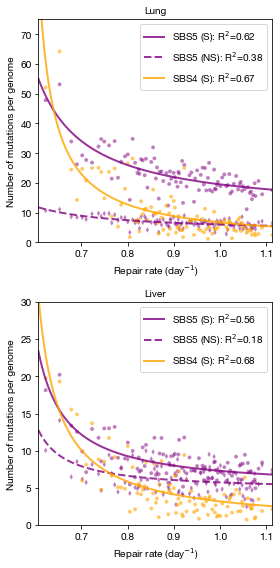

In [169]:
f,axs = plt.subplots(2,1, figsize=[4,8])

ax = axs[0]
sz = 15
plot_and_fit_curve(ax, yos,   "RepairRate", "nSBS5", "SBS5 (smokers)", "purple", s=sz, alpha=0.5)
plot_and_fit_curve(ax, yosns, "RepairRate", "nSBS5", "SBS5 (non-smokers)", "purple", s=sz, alpha=0.5, marker="d")
plot_and_fit_curve(ax, yos, "RepairRate", "nSBS4", "SBS4 (smokers)", "orange", s=sz, alpha=0.6)
ax.legend()
ax.set_ylabel("Number of mutations per genome")
ax.set_title("Lung", fontsize=10)
ax.set_ylim([0,75])

ax = axs[1]
sz = 15
plot_and_fit_curve(ax, ng,   "RepairRate", "nSBS5", "SBS5 (smokers)", "purple", s=sz, alpha=0.5)
plot_and_fit_curve(ax, ngns, "RepairRate", "nSBS5", "SBS5 (non-smokers)", "purple", s=sz, alpha=0.5, marker="d")
plot_and_fit_curve(ax, ng, "RepairRate", "nSBS4", "SBS4 (smokers)", "orange", s=sz, alpha=0.6)
ax.legend()
ax.set_title("Liver", fontsize=10)
ax.set_ylabel("Number of mutations per genome")
ax.set_ylim([0,30])

plt.tight_layout()
